In [ ]:
# Necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Add
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras import Model
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

print("TF version:", tf.__version__)

TF version: 2.15.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import the libraries
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/archive.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory("/tmp/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone",
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=64,
    image_size=(227, 227),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
 )

Found 12446 files belonging to 4 classes.
Using 9957 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory("/tmp/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone",
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(227, 227),
  batch_size=64)

Found 12446 files belonging to 4 classes.
Using 2489 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Cyst', 'Normal', 'Stone', 'Tumor']


In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 227, 227, 3)
(64,)


In [ ]:
 normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
output_class_units = 4
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(96, (11,11),strides=(4,4), activation='relu', input_shape=(227, 227, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2,2)),
  tf.keras.layers.Conv2D(256, (11,11),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(256, (7,7),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(384, (5,5),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(384, (3,3),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(384, (3,3),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dropout(0.8),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dense(output_class_units, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (Batch  (None, 55, 55, 96)        384       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       2973952   
                                                                 
 batch_normalization_1 (Bat  (None, 27, 27, 256)       1024      
 chNormalization)                                                
                                                        

In [ ]:
# Define learning rate
learning_rate = 0.0001

# Create Adam optimizer with the specified learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model using the Adam optimizer
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
    epochs=epochs,
   )

Epoch 1/30
156/156 [==============================] - 118s 584ms/step - loss: 2.1563 - accuracy: 0.6606 - val_loss: 1.5117 - val_accuracy: 0.7248
Epoch 2/30
156/156 [==============================] - 71s 458ms/step - loss: 0.5055 - accuracy: 0.8560 - val_loss: 0.4521 - val_accuracy: 0.8686
Epoch 3/30
156/156 [==============================] - 74s 476ms/step - loss: 0.4363 - accuracy: 0.8978 - val_loss: 0.2862 - val_accuracy: 0.9373
Epoch 4/30
156/156 [==============================] - 75s 480ms/step - loss: 0.2719 - accuracy: 0.9377 - val_loss: 0.2751 - val_accuracy: 0.9305
Epoch 5/30
156/156 [==============================] - 76s 490ms/step - loss: 0.3496 - accuracy: 0.9442 - val_loss: 0.1753 - val_accuracy: 0.9711
Epoch 6/30
156/156 [==============================] - 77s 491ms/step - loss: 0.2836 - accuracy: 0.9595 - val_loss: 0.1791 - val_accuracy: 0.9679
Epoch 7/30
156/156 [==============================] - 77s 491ms/step - loss: 0.3214 - accuracy: 0.9646 - val_loss: 1.8683 - val_a

39/39 [==============================] - 4s 102ms/step


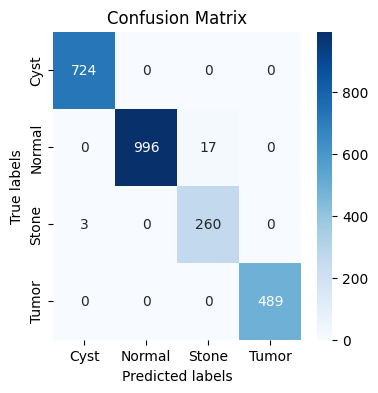

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict labels for the validation dataset
val_predictions = model.predict(val_ds)
val_pred_labels = np.argmax(val_predictions, axis=1)

# True labels for the validation dataset
true_labels = np.concatenate([y for x, y in val_ds], axis=0)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, val_pred_labels)


# Plot confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

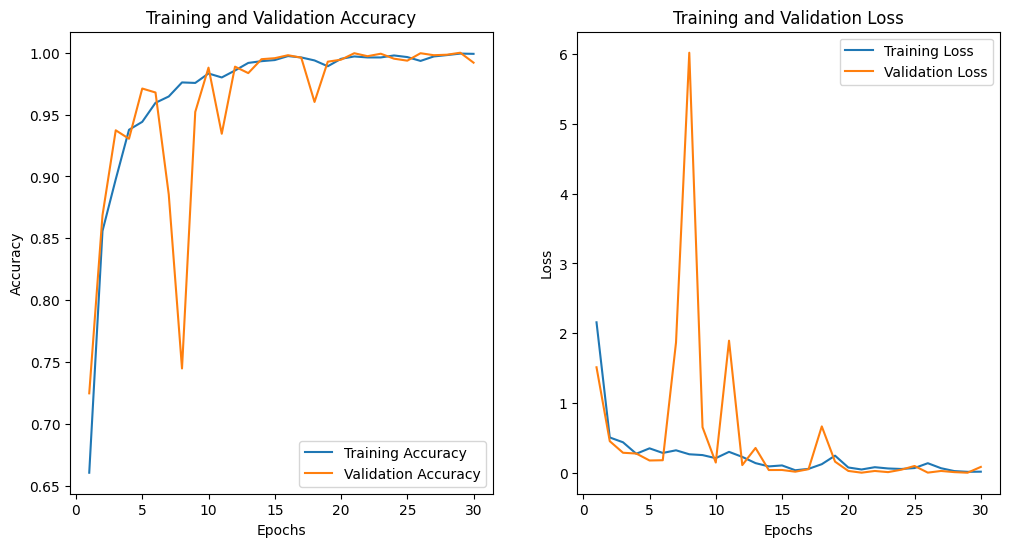

In [ ]:
# Training
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']

# Validation
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Number of epochs
epochs_range = range(1, epochs + 1)

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Compute classification report
report = classification_report(true_labels, val_pred_labels, target_names=class_names)

# Print classification report
print("Classification Report:")
print(report)

# Compute accuracy
accuracy = accuracy_score(true_labels, val_pred_labels)

# Print accuracy
print("Accuracy:", accuracy)


Classification Report:
              precision    recall  f1-score   support

        Cyst       1.00      1.00      1.00       724
      Normal       1.00      0.98      0.99      1013
       Stone       0.94      0.99      0.96       263
       Tumor       1.00      1.00      1.00       489

    accuracy                           0.99      2489
   macro avg       0.98      0.99      0.99      2489
weighted avg       0.99      0.99      0.99      2489

Accuracy: 0.9919646444355162
